In [3]:
# Enable autoreload to automatically update changes in modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import sys
from scipy.ndimage import gaussian_filter1d
sys.path.append("../src")  # Allows imports from 'src' directory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from general_utilities import load_nwb, get_units_tables, get_trial_timing # Import the function

In [5]:
# Set the path of the NWB file
filepath = "Z:\Kunpeng\Albus-S1_preproNWB\Albus-S1_TwoHands_psycho_NOpostchoice\exp2024-04-03-135625_prepro.nwb"# Open the file (dont forget to close it at the end "io.close()")
nwbfile = load_nwb(filepath)

In [6]:
units_tables, table_names = get_units_tables(nwbfile)
print(table_names)

['units-B1-129-160', 'units-C1-257-288', 'units-D1-385']


In [7]:
trials_timings = get_trial_timing(nwbfile)
#trials_timings['start_times']

In [8]:
unit_spike_times = units_tables[table_names[0]]["spike_times"][6]
start_times = trials_timings['start_times']
stop_times = trials_timings['stop_times']

In [9]:
def compute_average_firing_rate(unit_spike_times, align_times, window, bin_size = 0.05, smooth_sigma  = 2):
    time_bins = np.arange(window[0], window[1], bin_size)
    trial_spike_counts = np.zeros((len(align_times), len(time_bins) - 1))
    
    for trial_idx, align_time in enumerate(align_times):
        aligned_spikes = unit_spike_times - align_time  # Align spikes to event
        filtered_spikes = aligned_spikes[(aligned_spikes >= window[0]) & (aligned_spikes <= window[1])]
        hist, _ = np.histogram(filtered_spikes, bins=time_bins)  # Bin spike counts
        trial_spike_counts[trial_idx, :] = hist / bin_size  # Convert to rate (Hz)
    
    mean_firing_rate = np.mean(trial_spike_counts, axis=0)  # Average across trials
    smoothed_firing_rate = gaussian_filter1d(mean_firing_rate, sigma=smooth_sigma)  # Apply Gaussian smoothing
    return smoothed_firing_rate, time_bins

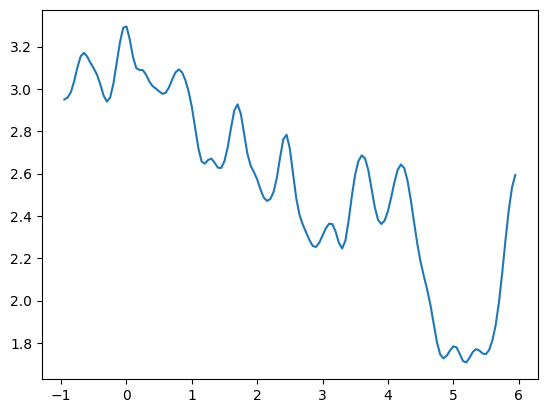

In [12]:
start_window = (-1, 6)  # Window around trial start (-1s to +6s)
stop_window = (-6, 1)   # Window around trial stop (-6s to +1s)
smoothed_firing_rate, time_bins = compute_average_firing_rate(unit_spike_times, start_times, window = start_window)
plt.plot(time_bins[1:], smoothed_firing_rate)

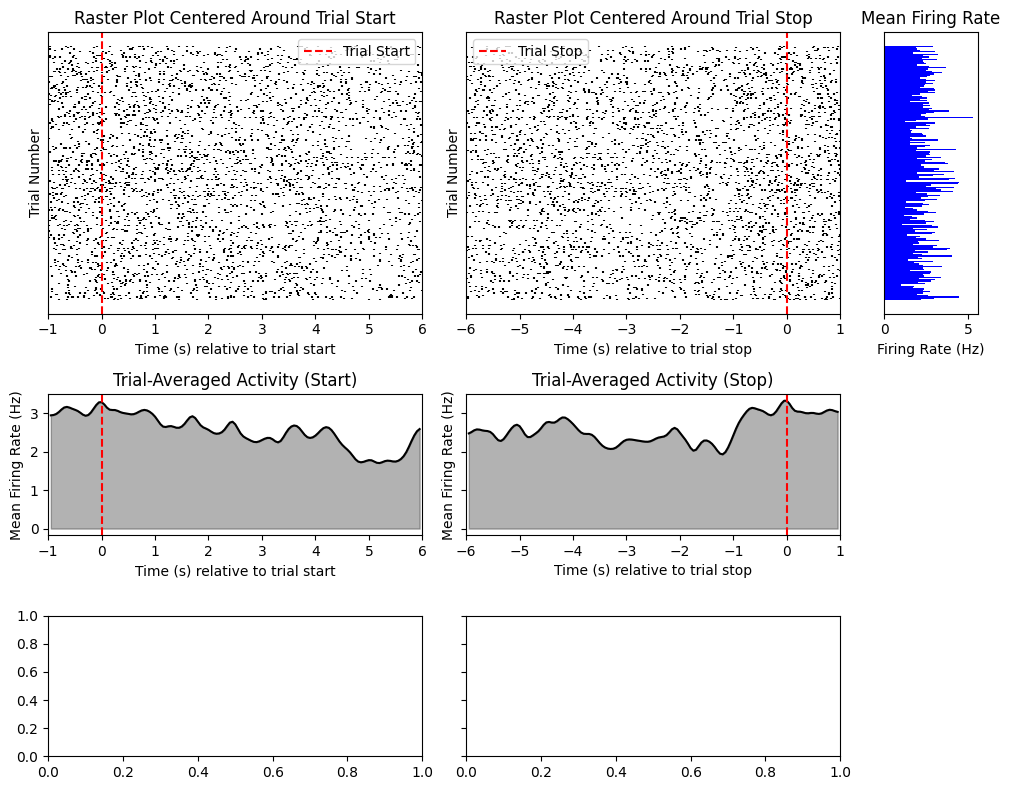

In [20]:
# Define time windows
start_window = (-1, 6)  # Window around trial start (-1s to +6s)
stop_window = (-6, 1)   # Window around trial stop (-6s to +1s)

# Compute trial-averaged firing rates using your function
smoothed_firing_rate_start, time_bins_start = compute_average_firing_rate(unit_spike_times, start_times, window=start_window)
smoothed_firing_rate_stop, time_bins_stop = compute_average_firing_rate(unit_spike_times, stop_times, window=stop_window)

# Compute trial-wise mean firing rate (for third row)
trial_firing_rates = []
for trial_idx in range(len(start_times)):
    trial_spikes = unit_spike_times[(unit_spike_times >= start_times[trial_idx]) & (unit_spike_times <= stop_times[trial_idx])]
    trial_duration = stop_times[trial_idx] - start_times[trial_idx]
    trial_firing_rates.append(len(trial_spikes) / trial_duration if trial_duration > 0 else 0)

# Create a 3×3 figure (Raster plots + Firing rate plot + Smoothed rate plot)
fig, axes = plt.subplots(
    ncols=3, 
    nrows=3, 
    figsize=(10, 8), 
    gridspec_kw={'width_ratios': [4, 4, 1], 'height_ratios': [2, 1, 1]},  # ✅ Set row height ratio
    sharey='row'
)  

### **Row 1: Raster Plots & Mean Firing Rate**
# Raster plot centered around trial start
axes[0, 0].set_title("Raster Plot Centered Around Trial Start")
for trial_idx, start_time in enumerate(start_times):
    aligned_spikes = unit_spike_times - start_time
    filtered_spikes = aligned_spikes[(aligned_spikes >= start_window[0]) & (aligned_spikes <= start_window[1])]
    axes[0, 0].eventplot(filtered_spikes, lineoffsets=trial_idx, colors='black')

axes[0, 0].axvline(0, color='red', linestyle='--', label="Trial Start")
axes[0, 0].set_xlim(start_window)
axes[0, 0].set_xlabel("Time (s) relative to trial start")
axes[0, 0].set_ylabel("Trial Number")
axes[0, 0].legend()

# Raster plot centered around trial stop
axes[0, 1].set_title("Raster Plot Centered Around Trial Stop")
for trial_idx, stop_time in enumerate(stop_times):
    aligned_spikes = unit_spike_times - stop_time
    filtered_spikes = aligned_spikes[(aligned_spikes >= stop_window[0]) & (aligned_spikes <= stop_window[1])]
    axes[0, 1].eventplot(filtered_spikes, lineoffsets=trial_idx, colors='black')

axes[0, 1].axvline(0, color='red', linestyle='--', label="Trial Stop")
axes[0, 1].set_xlim(stop_window)
axes[0, 1].set_xlabel("Time (s) relative to trial stop")
axes[0, 1].set_ylabel("Trial Number")
axes[0, 1].legend()

# Mean firing rate per trial (Row 1, Rightmost Panel)
axes[0, 2].barh(range(len(trial_firing_rates)), trial_firing_rates, color='blue', height=1)
axes[0, 2].set_title("Mean Firing Rate")
axes[0, 2].set_xlabel("Firing Rate (Hz)")
axes[0, 2].set_yticks([])

### **Row 2: Trial-Averaged Smoothed Activity (Now as Area Plot)**
# Trial-averaged activity centered on trial start
axes[1, 0].fill_between(time_bins_start[1:], smoothed_firing_rate_start, color='black', alpha=0.3)
axes[1, 0].plot(time_bins_start[1:], smoothed_firing_rate_start, color='black')
axes[1, 0].axvline(0, color='red', linestyle='--', label="Trial Start")
axes[1, 0].set_xlim(start_window)
axes[1, 0].set_xlabel("Time (s) relative to trial start")
axes[1, 0].set_ylabel("Mean Firing Rate (Hz)")
axes[1, 0].set_title("Trial-Averaged Activity (Start)")

# Trial-averaged activity centered on trial stop
axes[1, 1].fill_between(time_bins_stop[1:], smoothed_firing_rate_stop, color='black', alpha=0.3)
axes[1, 1].plot(time_bins_stop[1:], smoothed_firing_rate_stop, color='black')
axes[1, 1].axvline(0, color='red', linestyle='--', label="Trial Stop")
axes[1, 1].set_xlim(stop_window)
axes[1, 1].set_xlabel("Time (s) relative to trial stop")
axes[1, 1].set_ylabel("Mean Firing Rate (Hz)")
axes[1, 1].set_title("Trial-Averaged Activity (Stop)")

# Remove rightmost column in row 2 (not needed)
axes[1, 2].axis("off")

### **Row 3: Placeholder for Additional Graphs**
# Customize what to plot in the third row

# Example: Remove third-row right panel if unused
axes[2, 2].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

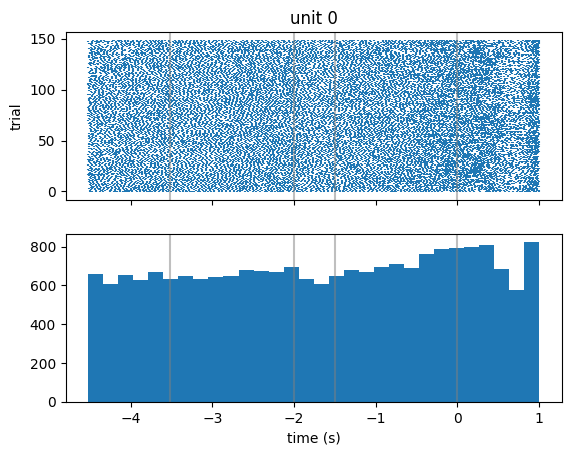

In [ ]:

nwbfile# Do some rasters#units_table = nwbfile.processing['units']['units-B1-129-160']
#num_units  = 34
units_table = nwbfile.processing['units']['units-C1-257-288']
num_units  = 27
trials_df = nwbfile.trials.to_dataframe()
before = 4.52  # in seconds
after = 1# Get the stimulus times for all stimuli
# get_timestamps() works whether the time is stored as an array of timestamps or as
# starting time and sampling rate.
choice_on_times = trials_df.loc[:, 'choiceTarget_ON_time']

#%matplotlib ipympl 

for unit in range(1):
    unit_spike_times = units_table["spike_times"][unit]
    trial_spikes = []
    for time in choice_on_times:
        if time>=0:
            # Compute spike times relative to stimulus onset
            aligned_spikes = unit_spike_times - time
            # Keep only spike times in a given time window around the stimulus onset
            aligned_spikes = aligned_spikes[
                (-before < aligned_spikes) & (aligned_spikes < after)
            ]
            trial_spikes.append(aligned_spikes)    
    fig, axs = plt.subplots(2, 1, sharex="all")    
    plt.xlabel("time (s)")
    axs[0].eventplot(trial_spikes)
    axs[0].set_ylabel("trial")
    axs[0].set_title("unit {}".format(unit))
    axs[0].axvline(-3.52, color=[0.5, 0.5, 0.5, 0.5])
    axs[0].axvline(-2, color=[0.5, 0.5, 0.5, 0.5])
    axs[0].axvline(-1.5, color=[0.5, 0.5, 0.5, 0.5])
    axs[0].axvline(0, color=[0.5, 0.5, 0.5, 0.5])    
    axs[1].hist(numpy.hstack(trial_spikes), 30)
    axs[1].axvline(-3.52, color=[0.5, 0.5, 0.5, 0.5])
    axs[1].axvline(-2, color=[0.5, 0.5, 0.5, 0.5])
    axs[1].axvline(-1.5, color=[0.5, 0.5, 0.5, 0.5])
    axs[1].axvline(0, color=[0.5, 0.5, 0.5, 0.5])

In [66]:
unit_spike_times = units_tables[table_names[0]]["spike_times"][1]
start_times = trials_timings['start_times']
stop_times = trials_timings['stop_times']

(0.0, 1.0, 0.0, 1.0)

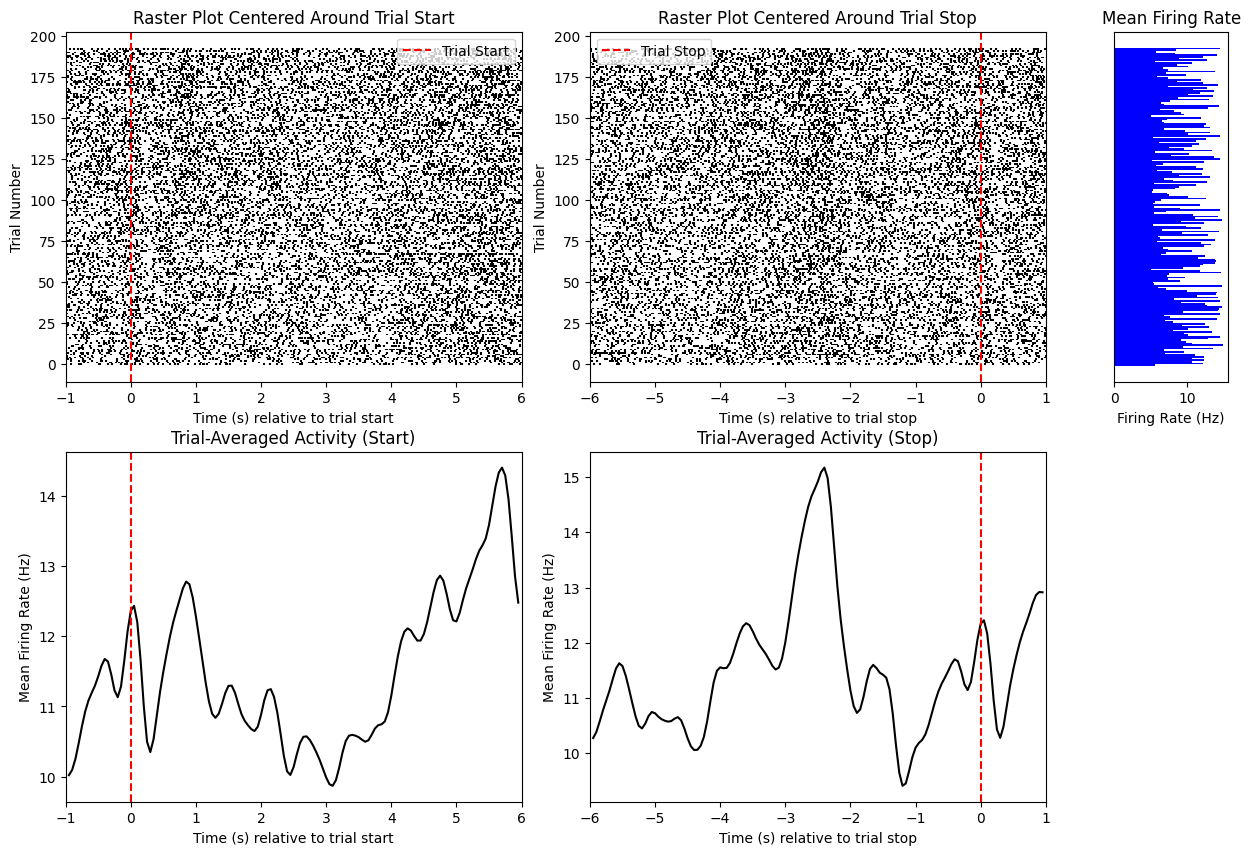

In [68]:
# Define time windows
start_window = (-1, 6)  # Window around trial start (-1s to +6s)
stop_window = (-6, 1)   # Window around trial stop (-6s to +1s)

# Compute trial-averaged firing rates
smoothed_firing_rate_start, time_bins_start = compute_average_firing_rate(unit_spike_times, start_times, window=start_window)
smoothed_firing_rate_stop, time_bins_stop = compute_average_firing_rate(unit_spike_times, stop_times, window=stop_window)

# Create a 3×2 figure (Raster plots + Firing rate plot + Smoothed rate plot)
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), gridspec_kw={'width_ratios': [4, 4, 1]})  

# Row 1: Raster plots
axes[0, 0].set_title("Raster Plot Centered Around Trial Start")
for trial_idx, start_time in enumerate(start_times):
    aligned_spikes = unit_spike_times - start_time
    filtered_spikes = aligned_spikes[(aligned_spikes >= start_window[0]) & (aligned_spikes <= start_window[1])]
    axes[0, 0].eventplot(filtered_spikes, lineoffsets=trial_idx, colors='black')

axes[0, 0].axvline(0, color='red', linestyle='--', label="Trial Start")
axes[0, 0].set_xlim(start_window)
axes[0, 0].set_xlabel("Time (s) relative to trial start")
axes[0, 0].set_ylabel("Trial Number")
axes[0, 0].legend()

axes[0, 1].set_title("Raster Plot Centered Around Trial Stop")
for trial_idx, stop_time in enumerate(stop_times):
    aligned_spikes = unit_spike_times - stop_time
    filtered_spikes = aligned_spikes[(aligned_spikes >= stop_window[0]) & (aligned_spikes <= stop_window[1])]
    axes[0, 1].eventplot(filtered_spikes, lineoffsets=trial_idx, colors='black')

axes[0, 1].axvline(0, color='red', linestyle='--', label="Trial Stop")
axes[0, 1].set_xlim(stop_window)
axes[0, 1].set_xlabel("Time (s) relative to trial stop")
axes[0, 1].set_ylabel("Trial Number")
axes[0, 1].legend()

# Rightmost column: Mean firing rate (Row 1)
firing_rates = np.random.uniform(5, 15, size=len(start_times))  # Replace with actual firing rates
axes[0, 2].barh(range(len(firing_rates)), firing_rates, color='blue', height=1)
axes[0, 2].set_title("Mean Firing Rate")
axes[0, 2].set_xlabel("Firing Rate (Hz)")
axes[0, 2].set_yticks([])

# Row 2: Smoothed firing rate
axes[1, 0].plot(time_bins_start[1:], smoothed_firing_rate_start, color='black')
axes[1, 0].axvline(0, color='red', linestyle='--', label="Trial Start")
axes[1, 0].set_xlim(start_window)
axes[1, 0].set_xlabel("Time (s) relative to trial start")
axes[1, 0].set_ylabel("Mean Firing Rate (Hz)")
axes[1, 0].set_title("Trial-Averaged Activity (Start)")

axes[1, 1].plot(time_bins_stop[1:], smoothed_firing_rate_stop, color='black')
axes[1, 1].axvline(0, color='red', linestyle='--', label="Trial Stop")
axes[1, 1].set_xlim(stop_window)
axes[1, 1].set_xlabel("Time (s) relative to trial stop")
axes[1, 1].set_ylabel("Mean Firing Rate (Hz)")
axes[1, 1].set_title("Trial-Averaged Activity (Stop)")

# Remove rightmost column in second row
axes[1, 2].axis("off")
